# PySDS Summative

## Get Wikipedia daily pageviews for all languages

In [2]:
import requests
import json
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np

### Get the language list / code existing for Bitcoin page

In [2]:
# Using wikipedia API to query langlinks
endpoint = 'http://en.wikipedia.org/w/api.php?action=query&meta=siteinfo&format=json'
# api.php?action=query&format=json&prop=langlinks&titles=Bitcoin&lllang=en&lllimit=100
result =  requests.get(endpoint)
response = result.json()
with open('langlinks', 'w') as outfile:
    json.dump(response, outfile)

In [4]:
def query(request): # query Wikipedia as a generator function
    request['action'] = 'query'
    request['format'] = 'json'
    lastContinue = {}
    while True:
        # Clone original request
        req = request.copy()
        # Modify it with the values returned in the 'continue' section of the last result.
        req.update(lastContinue)
        # Call API
        result = requests.get('https://en.wikipedia.org/w/api.php', params=req).json()
        if 'error' in result:
            print(result['error'])
            #raise Error(result['error'])
        if 'warnings' in result:
            print(result['warnings'])
        if 'query' in result:
            yield result['query']
        if 'continue' not in result:
            break
        lastContinue = result['continue']

# Get all the links
linksparams = {'titles':'Bitcoin', 'prop':'langlinks', 'pllimit':'max', 'plnamespace':'0'}
linksdata = list(query(linksparams))

In [30]:
# Finding the languages that have Bitcoin pages 
langList = [('en', 'Bitcoin')]
for i in linksdata:
    for j in i['pages']['28249265']['langlinks']:
        langList.append((j['lang'], j['*']))

print(len(langList))
langCode = [x[0] for x in langList]
langText = [x[1] for x in langList]

94


### Get pageviews for each language

In [26]:
endpoint = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'

In [27]:
# Create the empty dataframe
df_pageviews = pd.DataFrame(columns = langCode)

In [28]:
# Using Pageviews API to get pageviews for each language
print(len(langList))
for i in langList[:]:
    params = {'project' : '%s.wikipedia.org' % i[0],
                'access' : 'all-access',
                'agent' : 'all-agents',
                'article' : i[1],
                'granularity' : 'daily',
                'start' : '2015070100',
                'end' : '2018112800'} 

    api_call = requests.get(endpoint.format(**params))
    if 'error' in api_call:
        print('error occurs')
        print(api_call['error'])
    if 'warnings' in api_call:
        print(api_call['warnings'])

    response = api_call.json()

    try:
        temp = json_normalize(response['items'])
#         print('%s successful' % i[0])
    except:
#         print('%s ITEM ERROR' % i[0])
        langList.remove(i)
        df_pageviews.drop(i[0], axis=1)   
  
    try:
        if i == langList[0]:
            df_pageviews['Date'] = temp['timestamp'].map(lambda x: x[0:8])
            df_pageviews[i[0]] = temp['views']
#             df_pageviews['year'] = temp['timestamp'].map(lambda x: x[0:4])
#             df_pageviews['month'] = temp['timestamp'].map(lambda x: x[4:6])
#             df_pageviews['day'] = temp['timestamp'].map(lambda x: x[6:8])
        else: 
            df_pageviews[i[0]] = temp['views']
    except: 
        print('%s VIEW ERROR' % i[0])
        
df_pageviews.set_index('Date', inplace=True)

94


In [ ]:
# Check missing entries
pd.isnull(df_pageviews).sum()
# Fill all missing entries with 0
df_pageviews.fillna(value=0,inplace=True)
# Save the result to .csv file for easy access
df_pageviews.to_csv('Pageview_by_langCode.csv')

In [ ]:
# Group the languages (langcode) that have the same title (langtext)
langText = [x[1] for x in langList]
df_pageviews.loc['Text'] = langText
df_pageviews = df_pageviews.T

df_pageviews_daily = df_pageviews.groupby('Text', axis = 0).sum()
df_pageviews_daily.to_csv('Pageview_by_langtext.csv')

## Get Google trend data

In [3]:
df_pageviews_daily = pd.read_csv('Pageview_by_langtext.csv')
df_pageviews_daily.set_index('Text', inplace=True)
df_pageviews_daily.head()

,20150701,20150702,20150703,20150704,20150705,20150706,20150707,20150708,20150709,20150710,...,20181119,20181120,20181121,20181122,20181123,20181124,20181125,20181126,20181127,20181128
Text,,,,,,,,,,,,,,,,,,,,,
Bitcoin,19861.0,16266.0,16466.0,14963.0,14670.0,18197.0,17568.0,18260.0,17305.0,15003.0,...,23798.0,27662.0,26878.0,27810.0,20380.0,17544.0,20720.0,30356.0,29663.0,23116.0
Bitkoin,14.0,33.0,26.0,5.0,14.0,11.0,10.0,8.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Bitmono,2.0,4.0,4.0,1.0,3.0,4.0,2.0,5.0,4.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Sarafu ya Bit,7.0,1.0,1.0,1.0,1.0,2.0,3.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Биткоин,11.0,12.0,4.0,4.0,10.0,13.0,8.0,11.0,6.0,11.0,...,13.0,13.0,17.0,24.0,7.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# Find the titles of pages that have the Top 15 pageviews
df_pageviews_daily['sum'] = df_pageviews_daily.sum(axis=1)
top15 = df_pageviews_daily.iloc[:,-1].sort_values().tail(15)
langList = list(top15.index)
langList

['Биткоин',
 'বিটকয়েন',
 'பிட்காயின்',
 'ბიტკოინი',
 'Биткојн',
 'บิตคอยน์',
 'बिटकॉइन',
 'ביטקוין',
 'بیت\u200cکوین',
 '비트코인',
 'بيتكوين',
 'ビットコイン',
 '比特币',
 'Биткойн',
 'Bitcoin']

In [5]:
# deleting'บิตคอยน์' because there's no google trend interest data for it
langList.remove('บิตคอยน์') 

In [6]:
# Format pageview dataframe in a nice way and change index into datetime format
df_pageviews_daily = df_pageviews_daily.T
df_pageviews_daily = df_pageviews_daily[langList].copy().iloc[:-1,:]
df_pageviews_daily.index =  df_pageviews_daily.index.map(lambda i: datetime.strptime(i, "%Y%m%d"))

In [7]:
display(df_pageviews_daily.head())
df_pageviews_daily.to_csv('visu_wiki.csv')

Text,Биткоин,বিটকয়েন,பிட்காயின்,ბიტკოინი,Биткојн,बिटकॉइन,ביטקוין,بیت‌کوین,비트코인,بيتكوين,ビットコイン,比特币,Биткойн,Bitcoin
2015-07-01,11.0,10.0,7.0,19.0,2.0,22.0,69.0,71.0,127.0,92.0,652.0,464.0,1459.0,19861.0
2015-07-02,12.0,6.0,2.0,26.0,8.0,12.0,154.0,118.0,107.0,86.0,721.0,466.0,1155.0,16266.0
2015-07-03,4.0,2.0,10.0,1.0,16.0,16.0,49.0,73.0,108.0,81.0,635.0,489.0,1009.0,16466.0
2015-07-04,4.0,1.0,12.0,12.0,11.0,7.0,68.0,71.0,89.0,89.0,485.0,368.0,757.0,14963.0
2015-07-05,10.0,4.0,5.0,7.0,12.0,9.0,83.0,67.0,81.0,94.0,569.0,360.0,757.0,14670.0


In [ ]:
# Install the pyseudo Google Trend API
!pip install pytrends

__repeat the following process for all Bitcoin languages__

In [ ]:
from pytrends.request import TrendReq
import time 

# Change kw_list, NOTE: keep the []
pytrends = TrendReq(hl='en-US', tz=360)

kw_list = ['Bitcoin']

pytrends.build_payload(kw_list, cat=0, timeframe='today 5-y', geo='', gprop='')
# pytrends = TrendReq(hl='en-US', tz=360, proxies = {'https': 'https://34.203.233.13:80'})
df_trend = pytrends.get_historical_interest(kw_list, year_start=2015, month_start=7, day_start=1, hour_start=0, year_end=2018, month_end=11, day_end=29, hour_end=0, cat=0, geo='', gprop='', sleep=0.005)

In [ ]:
# If no 429 errors or data for all dates are collected (seemingly), save the file
df_trend.to_csv('%s_trend_copy.csv' % 'Bitcoin', index=True)

__Now that the file for each language is ready, compile all of them into a single dataframe__

In [8]:
for i in langList:
    failed_list = []
    print('Reading.... %s' %i)
    try: 
        df_trend = pd.read_csv('%s_trend.csv' % i)
        df_trend.date = df_trend.date.map(lambda i: datetime.strptime(i, "%Y-%m-%d %H:%M:%S"))
        df_trend.set_index('date', inplace= True)
        if i == langList[0]:
            df_trend_daily = pd.DataFrame(index = df_trend.index)
        df_trend_daily = df_trend_daily.join(df_trend.iloc[:,:-1])
#         print('Join NOT WORKING')
    except: 
        print('%s FAILED' %i)
        failed_list.append(i)
    
#     df_trend.groupby('date', axis = 0).sum().iloc[:,-2]

Reading.... Биткоин
Reading.... বিটকয়েন
Reading.... பிட்காயின்
Reading.... ბიტკოინი
Reading.... Биткојн
Reading.... बिटकॉइन
Reading.... ביטקוין
Reading.... بیت‌کوین
Reading.... 비트코인
Reading.... بيتكوين
Reading.... ビットコイン
Reading.... 比特币
Reading.... Биткойн
Reading.... Bitcoin


In [9]:
df_trend_daily.isnull().sum()
# For some reason most languagues have missing data for some time points
# especially for Биткојн, so we are deleting this column
df_trend_daily.drop('Биткојн', axis = 1, inplace = True)
df_pageviews_daily.drop('Биткојн', axis = 1, inplace = True)
langList.remove('Биткојн')

In [10]:
# fill missing data with 0s
df_trend_daily.fillna(value=0,inplace=True)
# extract the date of indices
df_trend_daily.index = [i.date() for i in df_trend_daily.index]
# change index name 
df_trend_daily.index.name = 'Date'
# group data by date to obtain daily trend popularity
df_trend_daily = df_trend_daily.groupby(df_trend_daily.index, axis = 0).sum()

In [11]:
display(df_trend_daily.head())
# output the result to .csv file for easy access
df_trend_daily.to_csv('daily_trend.csv')

,Биткоин,বিটকয়েন,பிட்காயின்,ბიტკოინი,बिटकॉइन,ביטקוין,بیت‌کوین,비트코인,بيتكوين,ビットコイン,比特币,Биткойн,Bitcoin
Date,,,,,,,,,,,,,
2015-07-01,1393,294,0.0,175,100.0,417,199,99,600,0.0,0.0,523,983
2015-07-02,1321,191,154.0,225,0.0,556,212,104,344,0.0,100.0,531,889
2015-07-03,1108,28,0.0,170,0.0,150,307,0,534,81.0,0.0,365,859
2015-07-04,1169,157,82.0,156,0.0,285,229,0,506,100.0,0.0,574,870
2015-07-05,1279,265,100.0,394,0.0,420,312,0,614,0.0,0.0,507,953


## Analysis 

In [12]:
lang_lookup = pd.DataFrame(columns = ['Text', 'Language'])
lang_lookup['Text'] = langList
lang_lookup['Language'] = ['Bulgarian', 'Bengali', 'Tamil', 'Georgian', 'Marathi', 'Hebrew', 'Persian', 'Korean', 'Arabic', 'Japanese','Chinese', 'Mongolian', 'English']
lang_lookup

,Text,Language
0,Биткоин,Bulgarian
1,বিটকয়েন,Bengali
2,பிட்காயின்,Tamil
3,ბიტკოინი,Georgian
4,बिटकॉइन,Marathi
5,ביטקוין,Hebrew
6,بیت‌کوین,Persian
7,비트코인,Korean
8,بيتكوين,Arabic
9,ビットコイン,Japanese


In [13]:
df_trend_daily.columns = lang_lookup['Language']
df_pageviews_daily.columns = lang_lookup['Language']

In [18]:
df_pageviews_daily.describe()

Language,Bulgarian,Bengali,Tamil,Georgian,Marathi,Hebrew,Persian,Korean,Arabic,Japanese,Chinese,Mongolian,English
count,1247.000000,1247.000000,1247.000000,1247.000000,1247.000000,1247.000000,1247.000000,1247.000000,1247.000000,1247.000000,1247.000000,1247.000000,1247.000000
mean,25.781075,27.353649,28.617482,45.546111,165.373697,306.601443,542.194868,570.557338,867.623095,1900.075381,2469.387330,5484.264635,40601.692863
std,19.812387,35.427917,35.222960,87.931030,295.298516,611.138074,859.829328,1183.863533,1404.978112,2979.551497,3054.695689,6634.923475,50403.764560
min,0.000000,0.000000,0.000000,0.000000,3.000000,24.000000,27.000000,37.000000,37.000000,238.000000,262.000000,757.000000,10079.000000
25%,14.000000,7.000000,7.000000,4.000000,23.000000,77.000000,77.000000,137.500000,204.000000,615.500000,942.500000,2024.500000,17606.000000
50%,20.000000,16.000000,17.000000,14.000000,61.000000,123.000000,188.000000,200.000000,428.000000,897.000000,1415.000000,2756.000000,23083.000000
75%,30.000000,35.000000,39.000000,45.500000,177.500000,248.000000,623.000000,419.500000,862.500000,1969.000000,2962.000000,5992.500000,43411.000000
max,242.000000,634.000000,336.000000,1297.000000,2647.000000,6451.000000,7380.000000,14768.000000,12668.000000,42516.000000,36435.000000,56661.000000,538420.000000


In [19]:
df_trend_daily.describe()

Language,Bulgarian,Bengali,Tamil,Georgian,Marathi,Hebrew,Persian,Korean,Arabic,Japanese,Chinese,Mongolian,English
count,1.241000e+03,1.241000e+03,1.241000e+03,1.241000e+03,1.241000e+03,1241.000000,1.241000e+03,1.241000e+03,1.241000e+03,1.241000e+03,1.241000e+03,1.241000e+03,1.241000e+03
mean,4.952150e+04,2.183101e+04,5.085743e+03,9.117435e+03,2.804200e+04,27632.758259,1.908788e+04,1.105965e+05,9.082494e+04,1.018138e+05,8.758283e+04,3.664005e+04,1.821136e+05
std,1.503187e+05,1.301792e+05,7.510018e+04,8.797005e+04,1.291394e+05,104084.226233,1.022998e+05,4.027391e+05,2.946767e+05,3.729736e+05,3.299218e+05,1.291701e+05,5.478686e+05
min,1.600000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,14.000000,7.000000e+00,0.000000e+00,2.100000e+01,0.000000e+00,0.000000e+00,8.000000e+00,6.300000e+01
25%,1.015000e+03,2.080000e+02,0.000000e+00,1.450000e+02,1.130000e+02,440.000000,2.850000e+02,1.480000e+02,7.150000e+02,7.200000e+01,0.000000e+00,6.850000e+02,1.422000e+03
50%,1.205000e+03,3.120000e+02,7.400000e+01,2.430000e+02,4.380000e+02,635.000000,4.350000e+02,6.270000e+02,9.180000e+02,5.090000e+02,5.970000e+02,8.740000e+02,1.702000e+03
75%,1.406000e+03,4.270000e+02,1.640000e+02,3.730000e+02,6.810000e+02,948.000000,6.860000e+02,9.850000e+02,1.157000e+03,9.500000e+02,9.730000e+02,1.117000e+03,1.926000e+03
max,1.033761e+06,1.573338e+06,1.474781e+06,1.819020e+06,1.589813e+06,869337.000000,1.508208e+06,3.081218e+06,2.097938e+06,2.720780e+06,2.294630e+06,1.328402e+06,3.262208e+06


Plotting the data found that google trend is so not consistant because of missing data, but it gives specific numbers for each translation of Bitcoin, so we can compare across the trend columns to see the ranking order. Wikipedia pageview plot is very clear and consistant.

In [20]:
# plt.figure(figsize = (10,5))
# plt.plot(df_trend_daily.sum(axis=1))
# plt.ylabel('Total Google trend interest of all languages')
# plt.figure(figsize = (10,5))
# plt.plot(df_pageviews_daily .sum(axis=1))
# plt.ylabel('Total Wikipedia pageviews of all languages')
# sns.lineplot(data = df_trend_daily.sum(axis=1), palette="tab10", linewidth=2.5)

Text(0, 0.5, 'Daily Wikipedia pageviews of all languages')

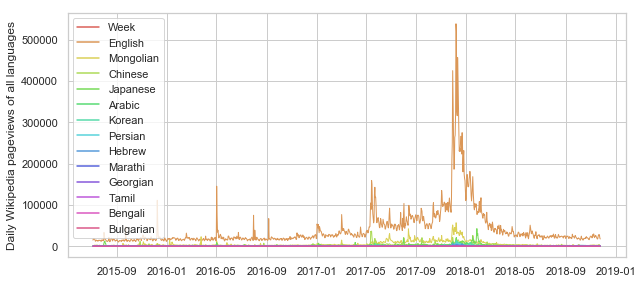

In [72]:
sns.set(rc={'figure.figsize':(10,4.5)})
sns.set_style("whitegrid")
ax = sns.lineplot(data = df_pageviews_daily.iloc[:, ::-1], dashes = False, palette="hls", linewidth=1.0)
ax.set_ylabel('Daily Wikipedia pageviews of all languages')

Text(0, 0.5, 'Daily Google trend interest of all languages')

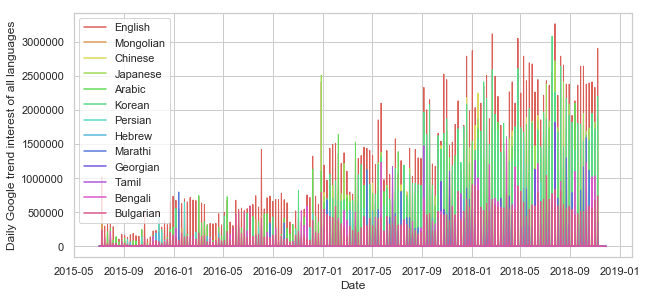

In [73]:
ax = sns.lineplot(data = df_trend_daily.iloc[:, ::-1], dashes = False, palette="hls", linewidth=1.0)
ax.set_ylabel('Daily Google trend interest of all languages')

In [21]:
df_trend_weekly = pd.read_csv('web_trend.csv')
df_trend_weekly.head()

,Week,Биткоин,বিটকয়েন,பிட்காயின்,ბიტკოინი,बिटकॉइन,ביטקוין,بیت‌کوین,비트코인,بيتكوين,ビットコイン,比特币,Биткойн,bitcoin
0,2015-07-05,2,18,31,0,0,1,9,<1,1,1,3,2,2
1,2015-07-12,3,0,0,0,0,1,0,1,2,1,2,3,2
2,2015-07-19,3,0,0,7,0,1,5,1,3,1,2,2,2
3,2015-07-26,3,0,0,0,0,1,0,<1,3,3,2,2,2
4,2015-08-02,2,0,0,0,0,1,0,<1,3,5,4,3,2


Text(0, 0.5, 'Weekly Google trend interest of all languages (weelly)')

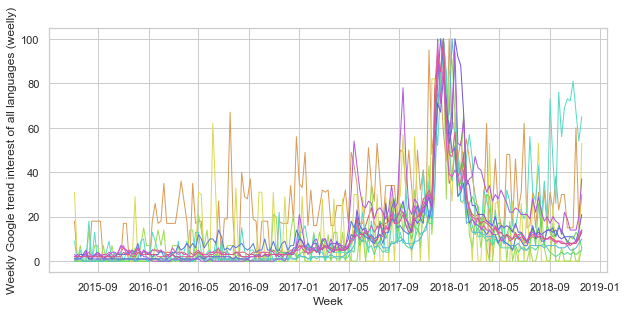

In [257]:
ax = sns.lineplot(data = df_trend_weekly, dashes = False, palette="hls", linewidth=1.0, legend = False)
ax.set_ylabel('Weekly Google trend interest of all languages (weelly)')

In [39]:
# find the days that have the top 15 trend interest/pageviews
trend_date = df_trend_daily.sum(axis=1).sort_values(ascending=False).head(15).index
wiki_date = df_pageviews_daily .sum(axis=1).sort_values(ascending=False).head(15).index

# find the overall corresponding trend interest/pageviews for the languages 
trend_lang = df_trend_daily.sum(axis=0)
wiki_lang = df_pageviews_daily.sum(axis=0)

In [30]:
df_lang = pd.DataFrame(index = trend_lang.index)
df_lang['wiki pageview'] = wiki_lang
df_lang['google trend'] = trend_lang
display(df_lang)
df_lang.to_csv('Pageview_by_langCode.csv')
df_lang_norm = (df_lang - df_lang.mean()) / (df_lang.max() - df_lang.min())

,wiki pageview,google trend
Language,,
Bulgarian,32149.0,61456178.0
Bengali,34110.0,27092289.0
Tamil,35686.0,6311407.0
Georgian,56796.0,11314737.0
Marathi,206221.0,34800124.0
Hebrew,382332.0,34292253.0
Persian,676117.0,23688065.0
Korean,711485.0,137250274.0
Arabic,1081926.0,112713756.0


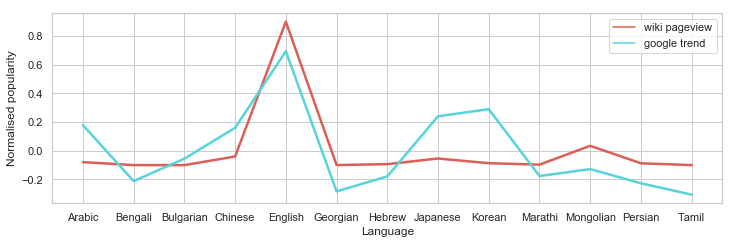

In [70]:
sns.set(rc={'figure.figsize':(12,3.5)})
sns.set_style("whitegrid")
ax = sns.lineplot(data = df_lang_norm, palette='hls',dashes = False, linewidth=2.5)
ax.set_ylabel('Normalised popularity')
plt.savefig('rank.png')

- It can be seen that for most the languages, the ranking of google trend interest is in accordance with wiki pageviews

In [37]:
df_date = pd.DataFrame()
# change type into datetime.date()
wiki_date = [i.date() for i in wiki_date]
df_date['Wiki pageview'] =wiki_date
df_date['Google trend'] = trend_date
df_date['Difference'] = df_date['Google trend'] - df_date['Wiki pageview']
display(df_date)
df_date['Difference'].mean()

,Wiki pageview,Google trend,Difference
0,2017-12-07,2018-07-25,230 days
1,2017-12-08,2018-07-18,222 days
2,2017-12-11,2018-07-04,205 days
3,2017-11-29,2018-02-21,84 days
4,2017-12-12,2018-08-08,239 days
5,2017-11-30,2017-12-20,20 days
6,2017-12-13,2018-04-25,133 days
7,2017-12-09,2018-01-17,39 days
8,2017-12-10,2018-02-28,80 days
9,2017-12-06,2018-06-13,189 days


Timedelta('137 days 04:48:00')

In [45]:
# df_date.to_latex()

It is found that out of the 15 days with top pageview/trend interest, days of most visits for Wikipedia are all in 2017 (mostly December), while for google trend, only one day is in 2017 (13th) and the rest of days are all in 2018. 

In order to find the correlation we need to use trend interest accessed from the Google trend web page, which is more consistent. 

Date: week beginning Sunday

The resulting numbers then get scaled on a range of 0 to 100 

In [42]:
df_trend_weekly = pd.read_csv('web_trend.csv')

In [43]:
# Last full week: week starting 2018-11-18 so we need to get rid of the last row
df_trend_weekly = df_trend_weekly[:-1]
# change <1 into 0.5 as an approximation
df_trend_weekly = df_trend_weekly.replace('<1', 0)
# change Week into index and format into datetime format
df_trend_weekly.set_index('Week', inplace=True)
df_trend_weekly.index = df_trend_weekly.index.map(lambda i: datetime.strptime(i, "%Y-%m-%d"))
print('Number of weeks:', len(df_trend_weekly.index))
# change the columns to languages
df_trend_weekly.columns = lang_lookup['Language']

Number of weeks: 177


In [44]:
# convert Series type into int
df_trend_weekly = df_trend_weekly.astype(str).astype(int)
print(df_trend_weekly.dtypes)

Language
Bulgarian    int64
Bengali      int64
Tamil        int64
Georgian     int64
Marathi      int64
Hebrew       int64
Persian      int64
Korean       int64
Arabic       int64
Japanese     int64
Chinese      int64
Mongolian    int64
English      int64
dtype: object


Now let's change the pageview data into the same format e.g weekly pageviews from 2015-07-05 to 2018-11-25

In [45]:
# strip data of incomplete weeks
df_pageviews_daily = df_pageviews_daily[4:-4]

In [46]:
import math

# set a number to indicate weeks
counter = range(0,len(df_pageviews_daily.index))
week = [math.floor(i / 7) for i in counter]
print(len(set(week))) # matches with trend index length

177


In [47]:
# Now group by weekly data
df_pageviews_daily['Week'] = week
df_pageviews_weekly = df_pageviews_daily.groupby(df_pageviews_daily['Week']).sum()
df_pageviews_weekly.set_index(df_trend_weekly.index, inplace=True)
df_pageviews_weekly.rename(index={'Text':'Week'}, inplace=True)
df_pageviews_weekly.head()

Language,Bulgarian,Bengali,Tamil,Georgian,Marathi,Hebrew,Persian,Korean,Arabic,Japanese,Chinese,Mongolian,English
Week,,,,,,,,,,,,,
2015-07-05,68.0,43.0,29.0,71.0,118.0,495.0,409.0,783.0,710.0,4753.0,3066.0,9281.0,112952.0
2015-07-12,101.0,20.0,18.0,52.0,48.0,506.0,410.0,793.0,564.0,7349.0,3035.0,12194.0,93130.0
2015-07-19,61.0,35.0,30.0,27.0,108.0,644.0,379.0,656.0,566.0,3077.0,2639.0,10661.0,95372.0
2015-07-26,75.0,29.0,29.0,35.0,79.0,400.0,370.0,853.0,546.0,13416.0,5878.0,8898.0,117002.0
2015-08-02,54.0,34.0,29.0,24.0,88.0,551.0,330.0,614.0,757.0,38771.0,4352.0,9759.0,111585.0


In [48]:
# Normalize both dataframes
df_pageviews_norm = (df_pageviews_weekly - df_pageviews_weekly.mean()) / (df_pageviews_weekly.max() - df_pageviews_weekly.min())
df_trend_norm = (df_trend_weekly - df_trend_weekly.mean()) / 100
# Rename 'bitcoin' to 'Bitcoin'
df_trend_norm.rename(columns={'bitcoin':'Bitcoin'}, inplace=True)

In [49]:
display(df_pageviews_norm.head())
display(df_trend_norm.head())

Language,Bulgarian,Bengali,Tamil,Georgian,Marathi,Hebrew,Persian,Korean,Arabic,Japanese,Chinese,Mongolian,English
Week,,,,,,,,,,,,,
2015-07-05,-0.188468,-0.128925,-0.110256,-0.073441,-0.078940,-0.065009,-0.083305,-0.059972,-0.087667,-0.069660,-0.114641,-0.099680,-0.073734
2015-07-12,-0.133651,-0.148769,-0.117289,-0.079033,-0.084233,-0.064578,-0.083280,-0.059786,-0.090044,-0.048615,-0.114890,-0.089764,-0.082226
2015-07-19,-0.200096,-0.135827,-0.109617,-0.086390,-0.079696,-0.059168,-0.084043,-0.062330,-0.090011,-0.083246,-0.118069,-0.094982,-0.081265
2015-07-26,-0.176840,-0.141004,-0.110256,-0.084036,-0.081889,-0.068732,-0.084265,-0.058672,-0.090337,0.000566,-0.092062,-0.100983,-0.072000
2015-08-02,-0.211724,-0.136690,-0.110256,-0.087273,-0.081208,-0.062814,-0.085250,-0.063110,-0.086902,0.206102,-0.104315,-0.098053,-0.074320


Language,Bulgarian,Bengali,Tamil,Georgian,Marathi,Hebrew,Persian,Korean,Arabic,Japanese,Chinese,Mongolian,English
Week,,,,,,,,,,,,,
2015-07-05,-0.100395,-0.074068,0.188418,-0.110734,-0.10565,-0.062825,-0.079605,-0.081299,-0.112486,-0.11435,-0.138362,-0.092373,-0.092316
2015-07-12,-0.090395,-0.254068,-0.121582,-0.110734,-0.10565,-0.062825,-0.169605,-0.071299,-0.102486,-0.11435,-0.148362,-0.082373,-0.092316
2015-07-19,-0.090395,-0.254068,-0.121582,-0.040734,-0.10565,-0.062825,-0.119605,-0.071299,-0.092486,-0.11435,-0.148362,-0.092373,-0.092316
2015-07-26,-0.090395,-0.254068,-0.121582,-0.110734,-0.10565,-0.062825,-0.169605,-0.081299,-0.092486,-0.09435,-0.148362,-0.092373,-0.092316
2015-08-02,-0.100395,-0.254068,-0.121582,-0.110734,-0.10565,-0.062825,-0.169605,-0.081299,-0.092486,-0.07435,-0.128362,-0.082373,-0.092316


In [68]:
# Plot for each languages and find correlation
from scipy.stats.stats import pearsonr
def gc(lang):
    data = pd.DataFrame(df_pageviews_norm[lang])
    data = data.merge(df_trend_norm[lang].to_frame(), left_index=True, right_index=True, suffixes=('_wiki', '_google'))
    ax = data.plot(kind='line', figsize = (8,5))
    ax.legend(loc = 'upper left')
    corr = pearsonr(df_pageviews_norm[lang], df_trend_norm[lang])[0]
    p_val = pearsonr(df_pageviews_norm[lang], df_trend_norm[lang])[1]
    return corr, p_val

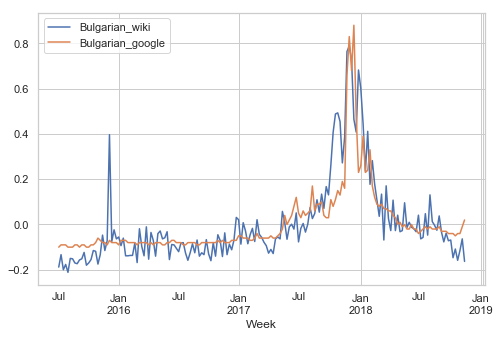

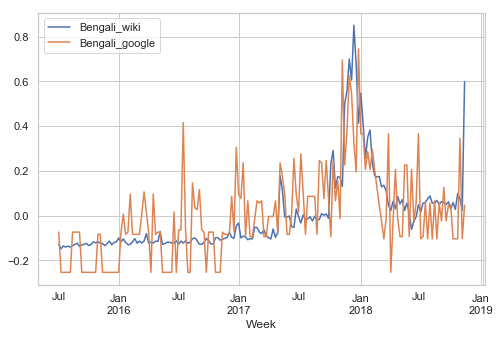

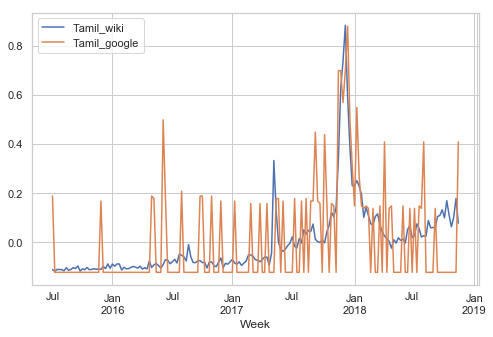

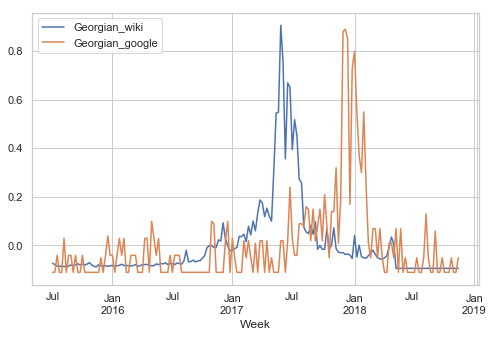

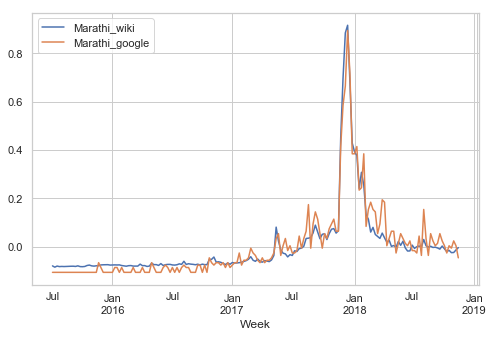

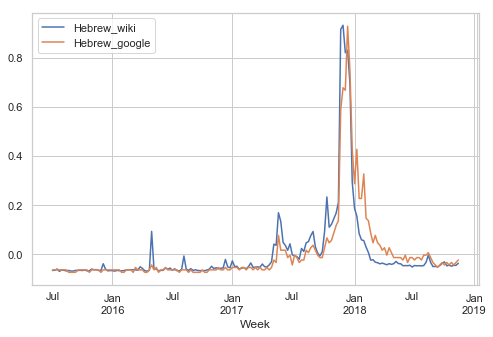

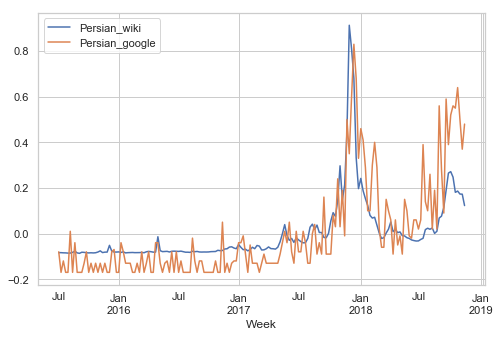

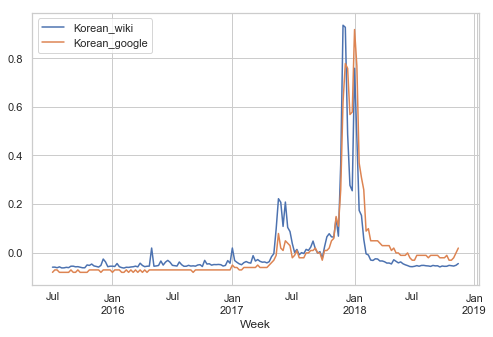

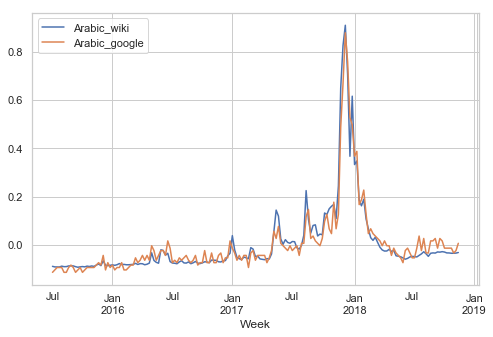

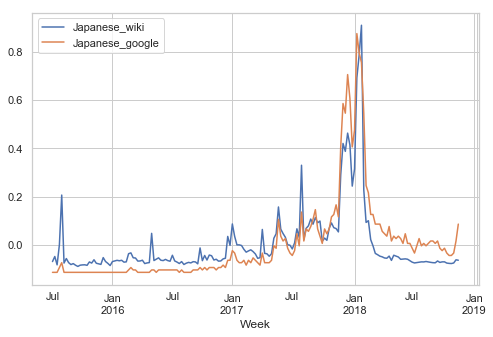

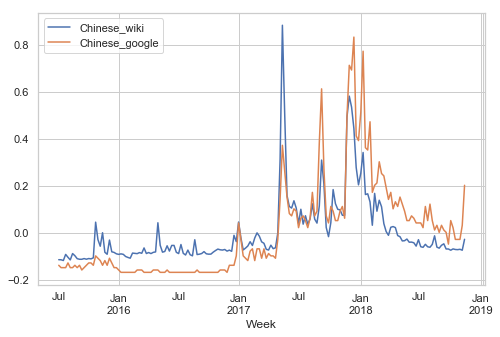

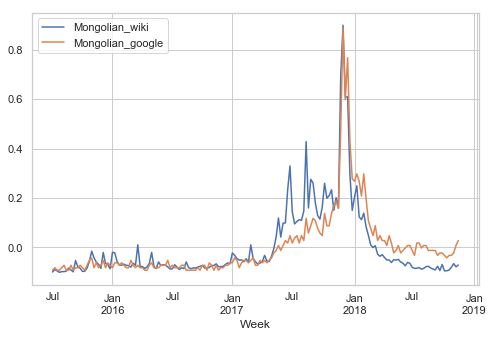

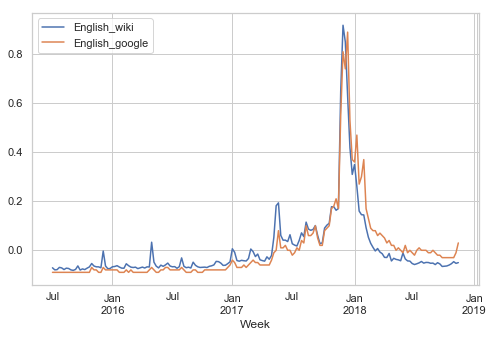

In [69]:
corr_dict = {}
for lang in lang_lookup['Language']:
    corr_dict[lang] = gc(lang)

In [57]:
a = df_pageviews_norm['Georgian'].sort_values(ascending = False).head(1)
b = df_trend_norm['Georgian'].sort_values(ascending = False).head(1)
print(a.index - b.index)

TimedeltaIndex(['-196 days'], dtype='timedelta64[ns]', name='Week', freq=None)


In [58]:
df_corr = pd.DataFrame.from_dict(corr_dict).T
df_corr.columns = ['Correlation coefficient', 'p value']
display(df_corr)

,Correlation coefficient,p value
Bulgarian,0.838453,5.260996e-48
Bengali,0.625112,1.408511e-20
Tamil,0.631556,4.324561e-21
Georgian,0.067152,3.745012e-01
Marathi,0.962124,1.038671e-100
Hebrew,0.921273,1.096397e-73
Persian,0.777933,3.733786e-37
Korean,0.894724,3.686183e-63
Arabic,0.968687,8.127784e-108
Japanese,0.902771,5.036822e-66


In [59]:
df_corr.to_latex()

'\\begin{tabular}{lrr}\n\\toprule\n{} &  Correlation coefficient &        p value \\\\\n\\midrule\nBulgarian &                 0.838453 &   5.260996e-48 \\\\\nBengali   &                 0.625112 &   1.408511e-20 \\\\\nTamil     &                 0.631556 &   4.324561e-21 \\\\\nGeorgian  &                 0.067152 &   3.745012e-01 \\\\\nMarathi   &                 0.962124 &  1.038671e-100 \\\\\nHebrew    &                 0.921273 &   1.096397e-73 \\\\\nPersian   &                 0.777933 &   3.733786e-37 \\\\\nKorean    &                 0.894724 &   3.686183e-63 \\\\\nArabic    &                 0.968687 &  8.127784e-108 \\\\\nJapanese  &                 0.902771 &   5.036822e-66 \\\\\nChinese   &                 0.825970 &   1.981536e-45 \\\\\nMongolian &                 0.887620 &   8.106806e-61 \\\\\nEnglish   &                 0.940781 &   3.926453e-84 \\\\\n\\bottomrule\n\\end{tabular}\n'

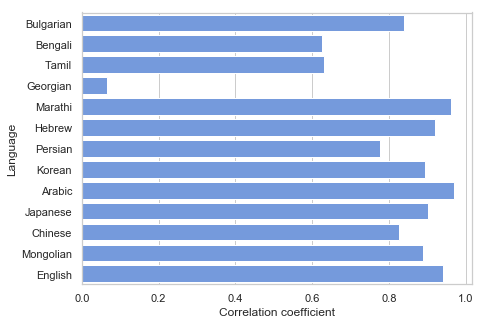

In [67]:
sns.set(rc={'figure.figsize':(7,5)})
sns.set_style("whitegrid")
ax = sns.barplot(x = df_corr['Correlation coefficient'], y = df_corr.index, color = 'cornflowerblue')
ax.set(xlabel='Correlation coefficient', ylabel='Language')
plt.show()

In [1]:
!Jupyter nbconvert --to pdf PySDS_summative.ipynb

[NbConvertApp] Converting notebook PySDS_summative.ipynb to pdf
[NbConvertApp] Support files will be in PySDS_summative_files/
[NbConvertApp] Making directory PySDS_summative_files
[NbConvertApp] Making directory PySDS_summative_files
[NbConvertApp] Making directory PySDS_summative_files
[NbConvertApp] Making directory PySDS_summative_files
[NbConvertApp] Making directory PySDS_summative_files
[NbConvertApp] Making directory PySDS_summative_files
[NbConvertApp] Making directory PySDS_summative_files
[NbConvertApp] Making directory PySDS_summative_files
[NbConvertApp] Making directory PySDS_summative_files
[NbConvertApp] Making directory PySDS_summative_files
[NbConvertApp] Making directory PySDS_summative_files
[NbConvertApp] Making directory PySDS_summative_files
[NbConvertApp] Making directory PySDS_summative_files
[NbConvertApp] Making directory PySDS_summative_files
[NbConvertApp] Making directory PySDS_summative_files
[NbConvertApp] Making directory PySDS_summative_files
[NbConver